In [235]:
# alpha:finish consulting; beta:new coming;
# overall timer format: (timepoint, event, station id, server id)

class Station:
    def __init__(self, stationid, overall_timer, process_param, n_server=0, n_buffer=0):
        self.stationid = stationid
        self.overall_timer = overall_timer
        self.s = n_server
        self.c = n_buffer
        self.wait = False
        self.status = [0, [0]*n_server] # 1 for occupied
        self.process_param = process_param
        self.next_station = None
    
    def setnext(self, next_station):
        self.next_station = next_station
        
    def printout(self):
        # print("time:{:.04f}".format(self.overall_timer[0][0]), " \tstation "+str(self.stationid)+":", self.status)
        return 0
    
    def update(self, timeslot):
        event= timeslot[1]
        if event == 'alpha':
            serverid = timeslot[3]
            succeed = self.alpha(serverid, timeslot)
        else:
            succeed = self.beta(timeslot)
            if not succeed:
                self.overall_timer.append((timeslot[0]+1, timeslot[1], timeslot[2]))
        del(self.overall_timer[0])
        self.overall_timer.sort(key= lambda k:(k[0], int(-k[2])))
        return succeed
        
    def alpha(self, serverid, timeslot):
        if self.next_station == None:
            if self.status[0] > 0: # wqiting line is not empty
                self.status[0] -= 1
                try:
                    self.overall_timer.append((timeslot[0]+np.random.exponential(self.process_param), 'alpha', self.stationid, serverid))
                    self.printout()
                except:
                    print("empty process time list for station", self.stationid, "server", serverid)
            else:
                self.status[1][serverid] = 0
                self.printout()
                return True
        else:
            if self.next_station.beta(timeslot):
                if self.status[0] > 0: # waiting line is not empty
                    self.status[0] -= 1
                    try:
                        self.overall_timer.append((self.overall_timer[0][0]+np.random.exponential(self.process_param), 'alpha', self.stationid, serverid))
                        # del(self.process_times[0])
                        self.printout()
                    except:
                        print("empty process time list for station", self.stationid, "server", serverid)
                else:
                    self.status[1][serverid] = 0
                    self.printout()
                    return True
            else:
                for i in range(len(self.overall_timer)):
                    if self.overall_timer[i][2]==self.stationid+1:
                        self.overall_timer.append((self.overall_timer[i][0], 'alpha', self.stationid, serverid))
                        self.overall_timer.sort(key= lambda k:(k[0], int(-k[2])))
                        return True
                self.overall_timer.append((self.overall_timer[0][0], 'alpha', self.stationid, serverid))
                self.overall_timer.sort(key= lambda k:(k[0], int(-k[2])))
            
    def beta(self, timeslot=None):
        if self.status[0] > 0: 
            if self.status[0]<self.c:
                self.status[0]+=1
                self.printout()
                return True
            else:
                return False
        else:
            i = 0
            while i < self.s:
                if self.status[1][i]==0:
                    self.status[1][i]=1
                    self.overall_timer.append((timeslot[0]+np.random.exponential(self.process_param), 'alpha', self.stationid, i))
                    # self.process_times.remove(self.process_times[0])
                    break
                else:
                    i += 1
            if i == self.s:
                self.status[0]+=1
            self.printout()
            return True
        

In [236]:
import numpy as np
class simulation:
    def run(n_customers):
        timer = []
        t = np.random.poisson(2.1, n_customers)
        for i in range(n_customers):
            timer.append((t[i], 'beta', 0))
        timer.sort(key= lambda k:k[0])
            
        stations = []
        stations.append(Station(stationid=0, overall_timer=timer, process_param=2.9, n_server=1, n_buffer=5))
        stations.append(Station(stationid=1, overall_timer=timer, process_param=2.2, n_server=1, n_buffer=6))
        stations.append(Station(stationid=2, overall_timer=timer, process_param=2.2, n_server=1, n_buffer=6))
        stations.append(Station(stationid=3, overall_timer=timer, process_param=2.8, n_server=1, n_buffer=3))
        stations[2].setnext(stations[3])
        stations[1].setnext(stations[2])
        stations[0].setnext(stations[1])
        
        tt = 0
        while len(timer)>0:
            # print(timer)
            tt = timer[0][0]
            stations[timer[0][2]].update(timer[0])
        return tt
            

In [237]:
simulation.run(n_customers=20)

87.36260820790893

In [238]:
import matplotlib.pyplot as plt
def conf_int_95(y):
    a = np.mean(y)
    b = np.sqrt(np.var(y, ddof=1))
    return (a-1.96*b, a+1.96*b)
def conf_int_80(y):
    a = np.mean(y)
    b = np.sqrt(np.var(y, ddof=1))
    return (a-1.28*b, a+1.28*b)

(59.0709087949697, 107.12600661621123)


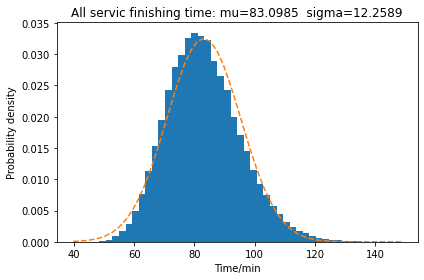

In [200]:
x0 = []
for i in range(100000):
    x0.append(simulation.run(n_customers=20))
x = np.array(x0)
print(conf_int_95(x))

num_bins =  50
mu, sigma = np.mean(x), np.std(x)
fig, ax = plt.subplots()
ax.set_title('All servic finishing time: mu='+str(round(mu, 4))+'  sigma='+str(round(sigma, 4)))
ax.set_xlabel('Time/min')
ax.set_ylabel('Probability density')

n, bins, patches = ax.hist(x, num_bins, density=True)

y = ((1 / (np.sqrt(2 * np.pi) * sigma)) *
     np.exp(-0.5 * (1 / sigma * (bins - mu))**2))
ax.plot(bins, y, '--')

fig.tight_layout()
plt.show()

0
iteration 0 :  0 %
iteration 0 :  10 %
iteration 0 :  20 %
iteration 0 :  30 %
iteration 0 :  40 %
iteration 0 :  50 %
iteration 0 :  60 %
iteration 0 :  70 %
iteration 0 :  80 %
iteration 0 :  90 %
1
iteration 1 :  0 %
iteration 1 :  10 %
iteration 1 :  20 %
iteration 1 :  30 %
iteration 1 :  40 %
iteration 1 :  50 %
iteration 1 :  60 %
iteration 1 :  70 %
iteration 1 :  80 %
iteration 1 :  90 %
2
iteration 2 :  0 %
iteration 2 :  10 %
iteration 2 :  20 %
iteration 2 :  30 %
iteration 2 :  40 %
iteration 2 :  50 %
iteration 2 :  60 %
iteration 2 :  70 %
iteration 2 :  80 %
iteration 2 :  90 %
3
iteration 3 :  0 %
iteration 3 :  10 %
iteration 3 :  20 %
iteration 3 :  30 %
iteration 3 :  40 %
iteration 3 :  50 %
iteration 3 :  60 %
iteration 3 :  70 %
iteration 3 :  80 %
iteration 3 :  90 %
4
iteration 4 :  0 %
iteration 4 :  10 %
iteration 4 :  20 %
iteration 4 :  30 %
iteration 4 :  40 %
iteration 4 :  50 %
iteration 4 :  60 %
iteration 4 :  70 %
iteration 4 :  80 %
iteration 4 :  

iteration 39 :  20 %
iteration 39 :  30 %
iteration 39 :  40 %
iteration 39 :  50 %
iteration 39 :  60 %
iteration 39 :  70 %
iteration 39 :  80 %
iteration 39 :  90 %
40
iteration 40 :  0 %
iteration 40 :  10 %
iteration 40 :  20 %
iteration 40 :  30 %
iteration 40 :  40 %
iteration 40 :  50 %
iteration 40 :  60 %
iteration 40 :  70 %
iteration 40 :  80 %
iteration 40 :  90 %
41
iteration 41 :  0 %
iteration 41 :  10 %
iteration 41 :  20 %
iteration 41 :  30 %
iteration 41 :  40 %
iteration 41 :  50 %
iteration 41 :  60 %
iteration 41 :  70 %
iteration 41 :  80 %
iteration 41 :  90 %
42
iteration 42 :  0 %
iteration 42 :  10 %
iteration 42 :  20 %
iteration 42 :  30 %
iteration 42 :  40 %
iteration 42 :  50 %
iteration 42 :  60 %
iteration 42 :  70 %
iteration 42 :  80 %
iteration 42 :  90 %
43
iteration 43 :  0 %
iteration 43 :  10 %
iteration 43 :  20 %
iteration 43 :  30 %
iteration 43 :  40 %
iteration 43 :  50 %
iteration 43 :  60 %
iteration 43 :  70 %
iteration 43 :  80 %
itera

iteration 77 :  90 %
78
iteration 78 :  0 %
iteration 78 :  10 %
iteration 78 :  20 %
iteration 78 :  30 %
iteration 78 :  40 %
iteration 78 :  50 %
iteration 78 :  60 %
iteration 78 :  70 %
iteration 78 :  80 %
iteration 78 :  90 %
79
iteration 79 :  0 %
iteration 79 :  10 %
iteration 79 :  20 %
iteration 79 :  30 %
iteration 79 :  40 %
iteration 79 :  50 %
iteration 79 :  60 %
iteration 79 :  70 %
iteration 79 :  80 %
iteration 79 :  90 %
80
iteration 80 :  0 %
iteration 80 :  10 %
iteration 80 :  20 %
iteration 80 :  30 %
iteration 80 :  40 %
iteration 80 :  50 %
iteration 80 :  60 %
iteration 80 :  70 %
iteration 80 :  80 %
iteration 80 :  90 %
81
iteration 81 :  0 %
iteration 81 :  10 %
iteration 81 :  20 %
iteration 81 :  30 %
iteration 81 :  40 %
iteration 81 :  50 %
iteration 81 :  60 %
iteration 81 :  70 %
iteration 81 :  80 %
iteration 81 :  90 %
82
iteration 82 :  0 %
iteration 82 :  10 %
iteration 82 :  20 %
iteration 82 :  30 %
iteration 82 :  40 %
iteration 82 :  50 %
ite

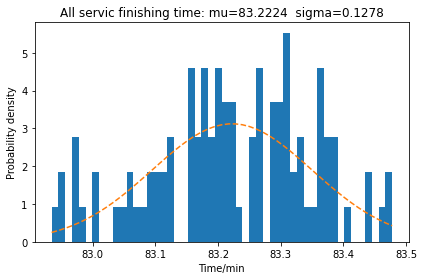

In [205]:
x0 = []
for i in range(100):
    print(i)
    x1 = []
    for j in range(10000):
        if j % 1000 == 0 :
            print("iteration", i, ": ", j//100, "%")
        x1.append(simulation.run(n_customers=20))
    # print(np.var(x1))
    x0.append(np.mean(x1))
x = np.array(x0)
# print(np.var(x0))
print(conf_int_95(x))

num_bins = 50
mu, sigma = np.mean(x), np.std(x)
fig, ax = plt.subplots()
ax.set_title('All servic finishing time: mu='+str(round(mu, 4))+'  sigma='+str(round(sigma, 4)))
ax.set_xlabel('Time/min')
ax.set_ylabel('Probability density')

n, bins, patches = ax.hist(x, num_bins, density=True)

y = ((1 / (np.sqrt(2 * np.pi) * sigma)) *
     np.exp(-0.5 * (1 / sigma * (bins - mu))**2))
ax.plot(bins, y, '--')

fig.tight_layout()
plt.show()

0
iteration 0 :  0 %
iteration 0 :  10 %
iteration 0 :  20 %
iteration 0 :  30 %
iteration 0 :  40 %
iteration 0 :  50 %
iteration 0 :  60 %
iteration 0 :  70 %
iteration 0 :  80 %
iteration 0 :  90 %
1
iteration 1 :  0 %
iteration 1 :  10 %
iteration 1 :  20 %
iteration 1 :  30 %
iteration 1 :  40 %
iteration 1 :  50 %
iteration 1 :  60 %
iteration 1 :  70 %
iteration 1 :  80 %
iteration 1 :  90 %
2
iteration 2 :  0 %
iteration 2 :  10 %
iteration 2 :  20 %
iteration 2 :  30 %
iteration 2 :  40 %
iteration 2 :  50 %
iteration 2 :  60 %
iteration 2 :  70 %
iteration 2 :  80 %
iteration 2 :  90 %
3
iteration 3 :  0 %
iteration 3 :  10 %
iteration 3 :  20 %
iteration 3 :  30 %
iteration 3 :  40 %
iteration 3 :  50 %
iteration 3 :  60 %
iteration 3 :  70 %
iteration 3 :  80 %
iteration 3 :  90 %
4
iteration 4 :  0 %
iteration 4 :  10 %
iteration 4 :  20 %
iteration 4 :  30 %
iteration 4 :  40 %
iteration 4 :  50 %
iteration 4 :  60 %
iteration 4 :  70 %
iteration 4 :  80 %
iteration 4 :  

iteration 39 :  20 %
iteration 39 :  30 %
iteration 39 :  40 %
iteration 39 :  50 %
iteration 39 :  60 %
iteration 39 :  70 %
iteration 39 :  80 %
iteration 39 :  90 %
40
iteration 40 :  0 %
iteration 40 :  10 %
iteration 40 :  20 %
iteration 40 :  30 %
iteration 40 :  40 %
iteration 40 :  50 %
iteration 40 :  60 %
iteration 40 :  70 %
iteration 40 :  80 %
iteration 40 :  90 %
41
iteration 41 :  0 %
iteration 41 :  10 %
iteration 41 :  20 %
iteration 41 :  30 %
iteration 41 :  40 %
iteration 41 :  50 %
iteration 41 :  60 %
iteration 41 :  70 %
iteration 41 :  80 %
iteration 41 :  90 %
42
iteration 42 :  0 %
iteration 42 :  10 %
iteration 42 :  20 %
iteration 42 :  30 %
iteration 42 :  40 %
iteration 42 :  50 %
iteration 42 :  60 %
iteration 42 :  70 %
iteration 42 :  80 %
iteration 42 :  90 %
43
iteration 43 :  0 %
iteration 43 :  10 %
iteration 43 :  20 %
iteration 43 :  30 %
iteration 43 :  40 %
iteration 43 :  50 %
iteration 43 :  60 %
iteration 43 :  70 %
iteration 43 :  80 %
itera

iteration 77 :  90 %
78
iteration 78 :  0 %
iteration 78 :  10 %
iteration 78 :  20 %
iteration 78 :  30 %
iteration 78 :  40 %
iteration 78 :  50 %
iteration 78 :  60 %
iteration 78 :  70 %
iteration 78 :  80 %
iteration 78 :  90 %
79
iteration 79 :  0 %
iteration 79 :  10 %
iteration 79 :  20 %
iteration 79 :  30 %
iteration 79 :  40 %
iteration 79 :  50 %
iteration 79 :  60 %
iteration 79 :  70 %
iteration 79 :  80 %
iteration 79 :  90 %
80
iteration 80 :  0 %
iteration 80 :  10 %
iteration 80 :  20 %
iteration 80 :  30 %
iteration 80 :  40 %
iteration 80 :  50 %
iteration 80 :  60 %
iteration 80 :  70 %
iteration 80 :  80 %
iteration 80 :  90 %
81
iteration 81 :  0 %
iteration 81 :  10 %
iteration 81 :  20 %
iteration 81 :  30 %
iteration 81 :  40 %
iteration 81 :  50 %
iteration 81 :  60 %
iteration 81 :  70 %
iteration 81 :  80 %
iteration 81 :  90 %
82
iteration 82 :  0 %
iteration 82 :  10 %
iteration 82 :  20 %
iteration 82 :  30 %
iteration 82 :  40 %
iteration 82 :  50 %
ite

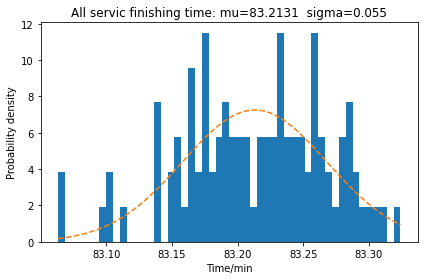

In [215]:
x0 = []
for i in range(100):
    print(i)
    x1 = []
    for j in range(50000):
        if j % 5000 == 0 :
            print("iteration", i, ": ", j//500, "%")
        x1.append(simulation.run(n_customers=20))
    # print(np.var(x1))
    x0.append(np.mean(x1))
x = np.array(x0)
# print(np.var(x0))
print(conf_int_95(x))

num_bins = 50
mu, sigma = np.mean(x), np.std(x)
fig, ax = plt.subplots()
ax.set_title('All servic finishing time: mu='+str(round(mu, 4))+'  sigma='+str(round(sigma, 4)))
ax.set_xlabel('Time/min')
ax.set_ylabel('Probability density')

n, bins, patches = ax.hist(x, num_bins, density=True)

y = ((1 / (np.sqrt(2 * np.pi) * sigma)) *
     np.exp(-0.5 * (1 / sigma * (bins - mu))**2))
ax.plot(bins, y, '--')

fig.tight_layout()
plt.show()

In [ ]:
print("50% CI:", conf_int_50(x))

num_bins = 20
mu, sigma = np.mean(x), np.std(x)
fig, ax = plt.subplots()
ax.set_title('All servic finishing time: mu='+str(round(mu, 4))+'  sigma='+str(round(sigma, 4)))
ax.set_xlabel('Time/min')
ax.set_ylabel('Probability density')
ax.set_xlim((82.9, 83.50))
n, bins, patches = ax.hist(x, num_bins, density=True)

y = ((1 / (np.sqrt(2 * np.pi) * sigma)) *
     np.exp(-0.5 * (1 / sigma * (bins - mu))**2))
ax.plot(bins, y, '--')

fig.tight_layout()
plt.show()

0
iteration 0.0 %:  0 %
iteration 0.0 %:  10 %
iteration 0.0 %:  20 %
iteration 0.0 %:  30 %
iteration 0.0 %:  40 %
iteration 0.0 %:  50 %
iteration 0.0 %:  60 %
iteration 0.0 %:  70 %
iteration 0.0 %:  80 %
iteration 0.0 %:  90 %
1
iteration 0.5 %:  0 %
iteration 0.5 %:  10 %
iteration 0.5 %:  20 %
iteration 0.5 %:  30 %
iteration 0.5 %:  40 %
iteration 0.5 %:  50 %
iteration 0.5 %:  60 %
iteration 0.5 %:  70 %
iteration 0.5 %:  80 %
iteration 0.5 %:  90 %
2
iteration 1.0 %:  0 %
iteration 1.0 %:  10 %
iteration 1.0 %:  20 %
iteration 1.0 %:  30 %
iteration 1.0 %:  40 %
iteration 1.0 %:  50 %
iteration 1.0 %:  60 %
iteration 1.0 %:  70 %
iteration 1.0 %:  80 %
iteration 1.0 %:  90 %
3
iteration 1.5 %:  0 %
iteration 1.5 %:  10 %
iteration 1.5 %:  20 %
iteration 1.5 %:  30 %
iteration 1.5 %:  40 %
iteration 1.5 %:  50 %
iteration 1.5 %:  60 %
iteration 1.5 %:  70 %
iteration 1.5 %:  80 %
iteration 1.5 %:  90 %
4
iteration 2.0 %:  0 %
iteration 2.0 %:  10 %
iteration 2.0 %:  20 %
iterat

iteration 17.0 %:  80 %
iteration 17.0 %:  90 %
35
iteration 17.5 %:  0 %
iteration 17.5 %:  10 %
iteration 17.5 %:  20 %
iteration 17.5 %:  30 %
iteration 17.5 %:  40 %
iteration 17.5 %:  50 %
iteration 17.5 %:  60 %
iteration 17.5 %:  70 %
iteration 17.5 %:  80 %
iteration 17.5 %:  90 %
36
iteration 18.0 %:  0 %
iteration 18.0 %:  10 %
iteration 18.0 %:  20 %
iteration 18.0 %:  30 %
iteration 18.0 %:  40 %
iteration 18.0 %:  50 %
iteration 18.0 %:  60 %
iteration 18.0 %:  70 %
iteration 18.0 %:  80 %
iteration 18.0 %:  90 %
37
iteration 18.5 %:  0 %
iteration 18.5 %:  10 %
iteration 18.5 %:  20 %
iteration 18.5 %:  30 %
iteration 18.5 %:  40 %
iteration 18.5 %:  50 %
iteration 18.5 %:  60 %
iteration 18.5 %:  70 %
iteration 18.5 %:  80 %
iteration 18.5 %:  90 %
38
iteration 19.0 %:  0 %
iteration 19.0 %:  10 %
iteration 19.0 %:  20 %
iteration 19.0 %:  30 %
iteration 19.0 %:  40 %
iteration 19.0 %:  50 %
iteration 19.0 %:  60 %
iteration 19.0 %:  70 %
iteration 19.0 %:  80 %
iteratio

iteration 34.0 %:  70 %
iteration 34.0 %:  80 %
iteration 34.0 %:  90 %
69
iteration 34.5 %:  0 %
iteration 34.5 %:  10 %
iteration 34.5 %:  20 %
iteration 34.5 %:  30 %
iteration 34.5 %:  40 %
iteration 34.5 %:  50 %
iteration 34.5 %:  60 %
iteration 34.5 %:  70 %
iteration 34.5 %:  80 %
iteration 34.5 %:  90 %
70
iteration 35.0 %:  0 %
iteration 35.0 %:  10 %
iteration 35.0 %:  20 %
iteration 35.0 %:  30 %
iteration 35.0 %:  40 %
iteration 35.0 %:  50 %
iteration 35.0 %:  60 %
iteration 35.0 %:  70 %
iteration 35.0 %:  80 %
iteration 35.0 %:  90 %
71
iteration 35.5 %:  0 %
iteration 35.5 %:  10 %
iteration 35.5 %:  20 %
iteration 35.5 %:  30 %
iteration 35.5 %:  40 %
iteration 35.5 %:  50 %
iteration 35.5 %:  60 %
iteration 35.5 %:  70 %
iteration 35.5 %:  80 %
iteration 35.5 %:  90 %
72
iteration 36.0 %:  0 %
iteration 36.0 %:  10 %
iteration 36.0 %:  20 %
iteration 36.0 %:  30 %
iteration 36.0 %:  40 %
iteration 36.0 %:  50 %
iteration 36.0 %:  60 %
iteration 36.0 %:  70 %
iteratio

iteration 51.0 %:  60 %
iteration 51.0 %:  70 %
iteration 51.0 %:  80 %
iteration 51.0 %:  90 %
103
iteration 51.5 %:  0 %
iteration 51.5 %:  10 %
iteration 51.5 %:  20 %
iteration 51.5 %:  30 %
iteration 51.5 %:  40 %
iteration 51.5 %:  50 %
iteration 51.5 %:  60 %
iteration 51.5 %:  70 %
iteration 51.5 %:  80 %
iteration 51.5 %:  90 %
104
iteration 52.0 %:  0 %
iteration 52.0 %:  10 %
iteration 52.0 %:  20 %
iteration 52.0 %:  30 %
iteration 52.0 %:  40 %
iteration 52.0 %:  50 %
iteration 52.0 %:  60 %
iteration 52.0 %:  70 %
iteration 52.0 %:  80 %
iteration 52.0 %:  90 %
105
iteration 52.5 %:  0 %
iteration 52.5 %:  10 %
iteration 52.5 %:  20 %
iteration 52.5 %:  30 %
iteration 52.5 %:  40 %
iteration 52.5 %:  50 %
iteration 52.5 %:  60 %
iteration 52.5 %:  70 %
iteration 52.5 %:  80 %
iteration 52.5 %:  90 %
106
iteration 53.0 %:  0 %
iteration 53.0 %:  10 %
iteration 53.0 %:  20 %
iteration 53.0 %:  30 %
iteration 53.0 %:  40 %
iteration 53.0 %:  50 %
iteration 53.0 %:  60 %
iter

iteration 68.0 %:  40 %
iteration 68.0 %:  50 %
iteration 68.0 %:  60 %
iteration 68.0 %:  70 %
iteration 68.0 %:  80 %
iteration 68.0 %:  90 %
137
iteration 68.5 %:  0 %
iteration 68.5 %:  10 %
iteration 68.5 %:  20 %
iteration 68.5 %:  30 %
iteration 68.5 %:  40 %
iteration 68.5 %:  50 %
iteration 68.5 %:  60 %
iteration 68.5 %:  70 %
iteration 68.5 %:  80 %
iteration 68.5 %:  90 %
138
iteration 69.0 %:  0 %
iteration 69.0 %:  10 %
iteration 69.0 %:  20 %
iteration 69.0 %:  30 %
iteration 69.0 %:  40 %
iteration 69.0 %:  50 %
iteration 69.0 %:  60 %
iteration 69.0 %:  70 %
iteration 69.0 %:  80 %
iteration 69.0 %:  90 %
139
iteration 69.5 %:  0 %
iteration 69.5 %:  10 %
iteration 69.5 %:  20 %
iteration 69.5 %:  30 %
iteration 69.5 %:  40 %
iteration 69.5 %:  50 %
iteration 69.5 %:  60 %
iteration 69.5 %:  70 %
iteration 69.5 %:  80 %
iteration 69.5 %:  90 %
140
iteration 70.0 %:  0 %
iteration 70.0 %:  10 %
iteration 70.0 %:  20 %
iteration 70.0 %:  30 %
iteration 70.0 %:  40 %
iter

iteration 85.0 %:  20 %
iteration 85.0 %:  30 %
iteration 85.0 %:  40 %
iteration 85.0 %:  50 %
iteration 85.0 %:  60 %
iteration 85.0 %:  70 %
iteration 85.0 %:  80 %
iteration 85.0 %:  90 %
171
iteration 85.5 %:  0 %
iteration 85.5 %:  10 %
iteration 85.5 %:  20 %
iteration 85.5 %:  30 %
iteration 85.5 %:  40 %
iteration 85.5 %:  50 %
iteration 85.5 %:  60 %
iteration 85.5 %:  70 %
iteration 85.5 %:  80 %
iteration 85.5 %:  90 %
172
iteration 86.0 %:  0 %
iteration 86.0 %:  10 %
iteration 86.0 %:  20 %
iteration 86.0 %:  30 %
iteration 86.0 %:  40 %
iteration 86.0 %:  50 %
iteration 86.0 %:  60 %
iteration 86.0 %:  70 %
iteration 86.0 %:  80 %
iteration 86.0 %:  90 %
173
iteration 86.5 %:  0 %
iteration 86.5 %:  10 %
iteration 86.5 %:  20 %
iteration 86.5 %:  30 %
iteration 86.5 %:  40 %
iteration 86.5 %:  50 %
iteration 86.5 %:  60 %
iteration 86.5 %:  70 %
iteration 86.5 %:  80 %
iteration 86.5 %:  90 %
174
iteration 87.0 %:  0 %
iteration 87.0 %:  10 %
iteration 87.0 %:  20 %
iter

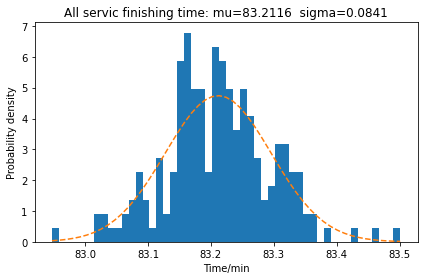

In [239]:
x0 = []
for i in range(200):
    print(i)
    x1 = []
    for j in range(20000):
        if j % 2000 == 0 :
            print("iteration", round(i/2, 2), "%: ", j//200, "%")
        x1.append(simulation.run(n_customers=20))
    x0.append(np.mean(x1))
x_200_20000_1_1 = np.array(x0)
print(conf_int_95(x_200_20000_1_1))

num_bins = 50
mu, sigma = np.mean(x_200_20000_1_1), np.std(x_200_20000_1_1)
fig, ax = plt.subplots()
ax.set_title('All servic finishing time: mu='+str(round(mu, 4))+'  sigma='+str(round(sigma, 4)))
ax.set_xlabel('Time/min')
ax.set_ylabel('Probability density')

n, bins, patches = ax.hist(x_200_20000_1_1, num_bins, density=True)

y = ((1 / (np.sqrt(2 * np.pi) * sigma)) *
     np.exp(-0.5 * (1 / sigma * (bins - mu))**2))
ax.plot(bins, y, '--')

fig.tight_layout()
plt.show()

In [206]:
class simulation1:
    def run(n_customers):
        timer = []
        t = np.random.poisson(2.1, n_customers)
        for i in range(n_customers):
            timer.append((t[i], 'beta', 0))
        timer.sort(key= lambda k:k[0])
            
        stations = []
        stations.append(Station(stationid=0, overall_timer=timer, process_param=2.9, n_server=1, n_buffer=5))
        stations.append(Station(stationid=1, overall_timer=timer, process_param=2.2, n_server=2, n_buffer=6))
        stations.append(Station(stationid=2, overall_timer=timer, process_param=2.2, n_server=3, n_buffer=6))
        stations.append(Station(stationid=3, overall_timer=timer, process_param=2.8, n_server=1, n_buffer=3))
        stations[2].setnext(stations[3])
        stations[1].setnext(stations[2])
        stations[0].setnext(stations[1])
        
        tt = 0
        while len(timer)>0:
            # print(timer)
            tt = timer[0][0]
            stations[timer[0][2]].update(timer[0])
        return tt
            

In [207]:
simulation1.run(n_customers=10)

37.78775967701146

(51.516242148658066, 101.22741201159319)


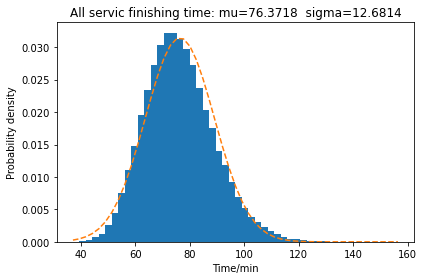

In [232]:
x0 = []
for i in range(100000):
    x0.append(simulation1.run(n_customers=20))
x_1_100000_2_3 = np.array(x0)
print(conf_int_95(x_1_100000_2_3))

num_bins =  50
mu, sigma = np.mean(x_1_100000_2_3), np.std(x_1_100000_2_3)
fig, ax = plt.subplots()
ax.set_title('All servic finishing time: mu='+str(round(mu, 4))+'  sigma='+str(round(sigma, 4)))
ax.set_xlabel('Time/min')
ax.set_ylabel('Probability density')

n, bins, patches = ax.hist(x_1_100000_2_3, num_bins, density=True)

y = ((1 / (np.sqrt(2 * np.pi) * sigma)) *
     np.exp(-0.5 * (1 / sigma * (bins - mu))**2))
ax.plot(bins, y, '--')

fig.tight_layout()
plt.show()

0
1
2
3
4
5
6
7
8
9
10
11
12
13
14
15
16
17
18
19
20
21
22
23
24
25
26
27
28
29
30
31
32
33
34
35
36
37
38
39
40
41
42
43
44
45
46
47
48
49
50
51
52
53
54
55
56
57
58
59
60
61
62
63
64
65
66
67
68
69
70
71
72
73
74
75
76
77
78
79
80
81
82
83
84
85
86
87
88
89
90
91
92
93
94
95
96
97
98
99
100
101
102
103
104
105
106
107
108
109
110
111
112
113
114
115
116
117
118
119
120
121
122
123
124
125
126
127
128
129
130
131
132
133
134
135
136
137
138
139
140
141
142
143
144
145
146
147
148
149
150
151
152
153
154
155
156
157
158
159
160
161
162
163
164
165
166
167
168
169
170
171
172
173
174
175
176
177
178
179
180
181
182
183
184
185
186
187
188
189
190
191
192
193
194
195
196
197
198
199
200
201
202
203
204
205
206
207
208
209
210
211
212
213
214
215
216
217
218
219
220
221
222
223
224
225
226
227
228
229
230
231
232
233
234
235
236
237
238
239
240
241
242
243
244
245
246
247
248
249
250
251
252
253
254
255
256
257
258
259
260
261
262
263
264
265
266
267
268
269
270
271
272
273
274
275
276
27

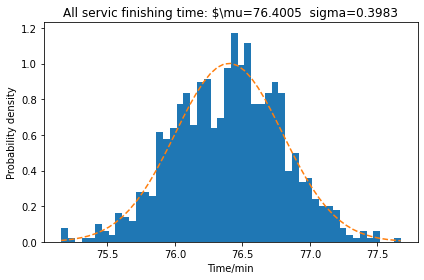

In [213]:
x0 = []
for i in range(1000):
    print(i)
    x1 = []
    for j in range(1000):
        x1.append(simulation1.run(n_customers=20))
    x0.append(np.mean(x1))
x = np.array(x0)
print(conf_int_95(x))

num_bins = 50
mu, sigma = np.mean(x), np.std(x)
fig, ax = plt.subplots()
ax.set_title('All servic finishing time: mu='+str(round(mu, 4))+'  sigma='+str(round(sigma, 4)))
ax.set_xlabel('Time/min')
ax.set_ylabel('Probability density')

n, bins, patches = ax.hist(x, num_bins, density=True)

y = ((1 / (np.sqrt(2 * np.pi) * sigma)) *
     np.exp(-0.5 * (1 / sigma * (bins - mu))**2))
ax.plot(bins, y, '--')

fig.tight_layout()
plt.show()

0
iteration 0.0 %:  0 %
iteration 0.0 %:  10 %
iteration 0.0 %:  20 %
iteration 0.0 %:  30 %
iteration 0.0 %:  40 %
iteration 0.0 %:  50 %
iteration 0.0 %:  60 %
iteration 0.0 %:  70 %
iteration 0.0 %:  80 %
iteration 0.0 %:  90 %
1
iteration 0.5 %:  0 %
iteration 0.5 %:  10 %
iteration 0.5 %:  20 %
iteration 0.5 %:  30 %
iteration 0.5 %:  40 %
iteration 0.5 %:  50 %
iteration 0.5 %:  60 %
iteration 0.5 %:  70 %
iteration 0.5 %:  80 %
iteration 0.5 %:  90 %
2
iteration 1.0 %:  0 %
iteration 1.0 %:  10 %
iteration 1.0 %:  20 %
iteration 1.0 %:  30 %
iteration 1.0 %:  40 %
iteration 1.0 %:  50 %
iteration 1.0 %:  60 %
iteration 1.0 %:  70 %
iteration 1.0 %:  80 %
iteration 1.0 %:  90 %
3
iteration 1.5 %:  0 %
iteration 1.5 %:  10 %
iteration 1.5 %:  20 %
iteration 1.5 %:  30 %
iteration 1.5 %:  40 %
iteration 1.5 %:  50 %
iteration 1.5 %:  60 %
iteration 1.5 %:  70 %
iteration 1.5 %:  80 %
iteration 1.5 %:  90 %
4
iteration 2.0 %:  0 %
iteration 2.0 %:  10 %
iteration 2.0 %:  20 %
iterat

iteration 17.0 %:  80 %
iteration 17.0 %:  90 %
35
iteration 17.5 %:  0 %
iteration 17.5 %:  10 %
iteration 17.5 %:  20 %
iteration 17.5 %:  30 %
iteration 17.5 %:  40 %
iteration 17.5 %:  50 %
iteration 17.5 %:  60 %
iteration 17.5 %:  70 %
iteration 17.5 %:  80 %
iteration 17.5 %:  90 %
36
iteration 18.0 %:  0 %
iteration 18.0 %:  10 %
iteration 18.0 %:  20 %
iteration 18.0 %:  30 %
iteration 18.0 %:  40 %
iteration 18.0 %:  50 %
iteration 18.0 %:  60 %
iteration 18.0 %:  70 %
iteration 18.0 %:  80 %
iteration 18.0 %:  90 %
37
iteration 18.5 %:  0 %
iteration 18.5 %:  10 %
iteration 18.5 %:  20 %
iteration 18.5 %:  30 %
iteration 18.5 %:  40 %
iteration 18.5 %:  50 %
iteration 18.5 %:  60 %
iteration 18.5 %:  70 %
iteration 18.5 %:  80 %
iteration 18.5 %:  90 %
38
iteration 19.0 %:  0 %
iteration 19.0 %:  10 %
iteration 19.0 %:  20 %
iteration 19.0 %:  30 %
iteration 19.0 %:  40 %
iteration 19.0 %:  50 %
iteration 19.0 %:  60 %
iteration 19.0 %:  70 %
iteration 19.0 %:  80 %
iteratio

iteration 34.0 %:  70 %
iteration 34.0 %:  80 %
iteration 34.0 %:  90 %
69
iteration 34.5 %:  0 %
iteration 34.5 %:  10 %
iteration 34.5 %:  20 %
iteration 34.5 %:  30 %
iteration 34.5 %:  40 %
iteration 34.5 %:  50 %
iteration 34.5 %:  60 %
iteration 34.5 %:  70 %
iteration 34.5 %:  80 %
iteration 34.5 %:  90 %
70
iteration 35.0 %:  0 %
iteration 35.0 %:  10 %
iteration 35.0 %:  20 %
iteration 35.0 %:  30 %
iteration 35.0 %:  40 %
iteration 35.0 %:  50 %
iteration 35.0 %:  60 %
iteration 35.0 %:  70 %
iteration 35.0 %:  80 %
iteration 35.0 %:  90 %
71
iteration 35.5 %:  0 %
iteration 35.5 %:  10 %
iteration 35.5 %:  20 %
iteration 35.5 %:  30 %
iteration 35.5 %:  40 %
iteration 35.5 %:  50 %
iteration 35.5 %:  60 %
iteration 35.5 %:  70 %
iteration 35.5 %:  80 %
iteration 35.5 %:  90 %
72
iteration 36.0 %:  0 %
iteration 36.0 %:  10 %
iteration 36.0 %:  20 %
iteration 36.0 %:  30 %
iteration 36.0 %:  40 %
iteration 36.0 %:  50 %
iteration 36.0 %:  60 %
iteration 36.0 %:  70 %
iteratio

iteration 51.0 %:  60 %
iteration 51.0 %:  70 %
iteration 51.0 %:  80 %
iteration 51.0 %:  90 %
103
iteration 51.5 %:  0 %
iteration 51.5 %:  10 %
iteration 51.5 %:  20 %
iteration 51.5 %:  30 %
iteration 51.5 %:  40 %
iteration 51.5 %:  50 %
iteration 51.5 %:  60 %
iteration 51.5 %:  70 %
iteration 51.5 %:  80 %
iteration 51.5 %:  90 %
104
iteration 52.0 %:  0 %
iteration 52.0 %:  10 %
iteration 52.0 %:  20 %
iteration 52.0 %:  30 %
iteration 52.0 %:  40 %
iteration 52.0 %:  50 %
iteration 52.0 %:  60 %
iteration 52.0 %:  70 %
iteration 52.0 %:  80 %
iteration 52.0 %:  90 %
105
iteration 52.5 %:  0 %
iteration 52.5 %:  10 %
iteration 52.5 %:  20 %
iteration 52.5 %:  30 %
iteration 52.5 %:  40 %
iteration 52.5 %:  50 %
iteration 52.5 %:  60 %
iteration 52.5 %:  70 %
iteration 52.5 %:  80 %
iteration 52.5 %:  90 %
106
iteration 53.0 %:  0 %
iteration 53.0 %:  10 %
iteration 53.0 %:  20 %
iteration 53.0 %:  30 %
iteration 53.0 %:  40 %
iteration 53.0 %:  50 %
iteration 53.0 %:  60 %
iter

iteration 68.0 %:  40 %
iteration 68.0 %:  50 %
iteration 68.0 %:  60 %
iteration 68.0 %:  70 %
iteration 68.0 %:  80 %
iteration 68.0 %:  90 %
137
iteration 68.5 %:  0 %
iteration 68.5 %:  10 %
iteration 68.5 %:  20 %
iteration 68.5 %:  30 %
iteration 68.5 %:  40 %
iteration 68.5 %:  50 %
iteration 68.5 %:  60 %
iteration 68.5 %:  70 %
iteration 68.5 %:  80 %
iteration 68.5 %:  90 %
138
iteration 69.0 %:  0 %
iteration 69.0 %:  10 %
iteration 69.0 %:  20 %
iteration 69.0 %:  30 %
iteration 69.0 %:  40 %
iteration 69.0 %:  50 %
iteration 69.0 %:  60 %
iteration 69.0 %:  70 %
iteration 69.0 %:  80 %
iteration 69.0 %:  90 %
139
iteration 69.5 %:  0 %
iteration 69.5 %:  10 %
iteration 69.5 %:  20 %
iteration 69.5 %:  30 %
iteration 69.5 %:  40 %
iteration 69.5 %:  50 %
iteration 69.5 %:  60 %
iteration 69.5 %:  70 %
iteration 69.5 %:  80 %
iteration 69.5 %:  90 %
140
iteration 70.0 %:  0 %
iteration 70.0 %:  10 %
iteration 70.0 %:  20 %
iteration 70.0 %:  30 %
iteration 70.0 %:  40 %
iter

iteration 85.0 %:  20 %
iteration 85.0 %:  30 %
iteration 85.0 %:  40 %
iteration 85.0 %:  50 %
iteration 85.0 %:  60 %
iteration 85.0 %:  70 %
iteration 85.0 %:  80 %
iteration 85.0 %:  90 %
171
iteration 85.5 %:  0 %
iteration 85.5 %:  10 %
iteration 85.5 %:  20 %
iteration 85.5 %:  30 %
iteration 85.5 %:  40 %
iteration 85.5 %:  50 %
iteration 85.5 %:  60 %
iteration 85.5 %:  70 %
iteration 85.5 %:  80 %
iteration 85.5 %:  90 %
172
iteration 86.0 %:  0 %
iteration 86.0 %:  10 %
iteration 86.0 %:  20 %
iteration 86.0 %:  30 %
iteration 86.0 %:  40 %
iteration 86.0 %:  50 %
iteration 86.0 %:  60 %
iteration 86.0 %:  70 %
iteration 86.0 %:  80 %
iteration 86.0 %:  90 %
173
iteration 86.5 %:  0 %
iteration 86.5 %:  10 %
iteration 86.5 %:  20 %
iteration 86.5 %:  30 %
iteration 86.5 %:  40 %
iteration 86.5 %:  50 %
iteration 86.5 %:  60 %
iteration 86.5 %:  70 %
iteration 86.5 %:  80 %
iteration 86.5 %:  90 %
174
iteration 87.0 %:  0 %
iteration 87.0 %:  10 %
iteration 87.0 %:  20 %
iter

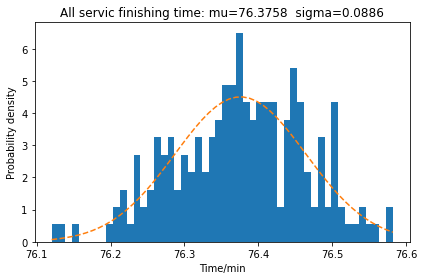

In [233]:
x0 = []
for i in range(200):
    print(i)
    x1 = []
    for j in range(20000):
        if j % 2000 == 0 :
            print("iteration", round(i/2, 2), "%: ", j//200, "%")
        x1.append(simulation1.run(n_customers=20))
    x0.append(np.mean(x1))
x_200_20000_2_3 = np.array(x0)
print(conf_int_95(x_200_20000_2_3))

num_bins = 50
mu, sigma = np.mean(x_200_20000_2_3), np.std(x_200_20000_2_3)
fig, ax = plt.subplots()
ax.set_title('All servic finishing time: mu='+str(round(mu, 4))+'  sigma='+str(round(sigma, 4)))
ax.set_xlabel('Time/min')
ax.set_ylabel('Probability density')

n, bins, patches = ax.hist(x_200_20000_2_3, num_bins, density=True)

y = ((1 / (np.sqrt(2 * np.pi) * sigma)) *
     np.exp(-0.5 * (1 / sigma * (bins - mu))**2))
ax.plot(bins, y, '--')

fig.tight_layout()
plt.show()

In [243]:
class simulation_1:
    def run(n_customers):
        timer = []
        t = np.random.poisson(2.1, n_customers+10)
        for i in range(n_customers+10):
            timer.append((t[i], 'beta', 0))
        timer.sort(key= lambda k:k[0])
            
        stations = []
        stations.append(Station(stationid=0, overall_timer=timer, process_param=2.9, n_server=1, n_buffer=5))
        stations.append(Station(stationid=1, overall_timer=timer, process_param=2.2, n_server=1, n_buffer=6))
        stations.append(Station(stationid=2, overall_timer=timer, process_param=2.2, n_server=1, n_buffer=6))
        stations.append(Station(stationid=3, overall_timer=timer, process_param=2.8, n_server=1, n_buffer=3))
        stations[2].setnext(stations[3])
        stations[1].setnext(stations[2])
        stations[0].setnext(stations[1])
        
        st = 0
        tt = 0
        counter = 0
        while len(timer)>0:
            # print(timer)
            if counter >= 10:
                st = timer[0][0]
            tt = timer[0][0]
            succeed = stations[timer[0][2]].update(timer[0])
            if st == 0 and succeed:
                if timer[0][1]=='beta':
                    counter += 1
        return tt-st
            

(4.483621909868701, 7.187092009235645)


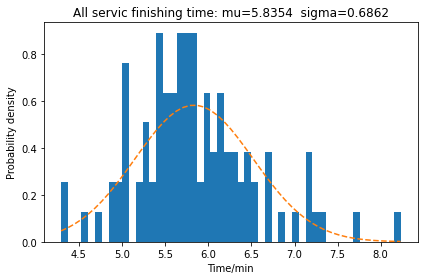

In [246]:
x0 = []
for i in range(100):
    x0.append(simulation_1.run(n_customers=20)/20)
x_warm_average = np.array(x0)
print(conf_int_95(x_warm_average))

num_bins =  50
mu, sigma = np.mean(x_warm_average), np.std(x_warm_average)
fig, ax = plt.subplots()
ax.set_title('All servic finishing time: mu='+str(round(mu, 4))+'  sigma='+str(round(sigma, 4)))
ax.set_xlabel('Time/min')
ax.set_ylabel('Probability density')

n, bins, patches = ax.hist(x_warm_average, num_bins, density=True)

y = ((1 / (np.sqrt(2 * np.pi) * sigma)) *
     np.exp(-0.5 * (1 / sigma * (bins - mu))**2))
ax.plot(bins, y, '--')

fig.tight_layout()
plt.show()

0 %
5 %
10 %
15 %
20 %
25 %
30 %
35 %
40 %
45 %
50 %
55 %
60 %
65 %
70 %
75 %
80 %
85 %
90 %
95 %
(88.18981234802138, 145.09083589626974)


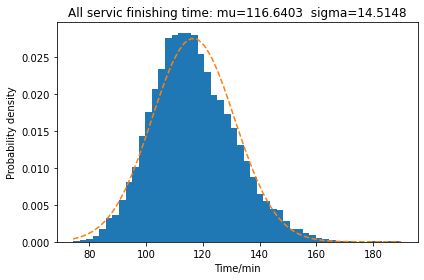

In [249]:
x0 = []
for i in range(10000):
    if i % 500 == 0:
        print(i//100, "%")
    x0.append(simulation_1.run(n_customers=20))
x_warm_10000 = np.array(x0)
print(conf_int_95(x_warm_10000))

num_bins =  50
mu, sigma = np.mean(x_warm_10000), np.std(x_warm_10000)
fig, ax = plt.subplots()
ax.set_title('All servic finishing time: mu='+str(round(mu, 4))+'  sigma='+str(round(sigma, 4)))
ax.set_xlabel('Time/min')
ax.set_ylabel('Probability density')

n, bins, patches = ax.hist(x_warm_10000, num_bins, density=True)

y = ((1 / (np.sqrt(2 * np.pi) * sigma)) *
     np.exp(-0.5 * (1 / sigma * (bins - mu))**2))
ax.plot(bins, y, '--')

fig.tight_layout()
plt.show()

0 %
2 %
4 %
6 %
8 %
10 %
12 %
14 %
16 %
18 %
20 %
22 %
24 %
26 %
28 %
30 %
32 %
34 %
36 %
38 %
40 %
42 %
44 %
46 %
48 %
50 %
52 %
54 %
56 %
58 %
60 %
62 %
64 %
66 %
68 %
70 %
72 %
74 %
76 %
78 %
80 %
82 %
84 %
86 %
88 %
90 %
92 %
94 %
96 %
98 %
(5.779915020018829, 5.89313414712091)


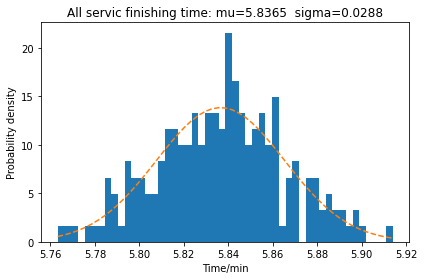

In [252]:
x0 = []
for i in range(200):
    if i % 4 == 0:
        print(i//2, "%")
    x1 = []
    for j in range(500):
        x1.append(simulation_1.run(n_customers=20)/20)
    x0.append(np.mean(x1))
x_warm_average_200_500_1_1 = np.array(x0)
print(conf_int_95(x_warm_average_200_500_1_1))

num_bins = 50
mu, sigma = np.mean(x_warm_average_200_500_1_1), np.std(x_warm_average_200_500_1_1)
fig, ax = plt.subplots()
ax.set_title('All servic finishing time: mu='+str(round(mu, 4))+'  sigma='+str(round(sigma, 4)))
ax.set_xlabel('Time/min')
ax.set_ylabel('Probability density')

n, bins, patches = ax.hist(x_warm_average_200_500_1_1, num_bins, density=True)

y = ((1 / (np.sqrt(2 * np.pi) * sigma)) *
     np.exp(-0.5 * (1 / sigma * (bins - mu))**2))
ax.plot(bins, y, '--')

fig.tight_layout()
plt.show()

0
iteration 0.0 %:  0 %
iteration 0.0 %:  10 %
iteration 0.0 %:  20 %
iteration 0.0 %:  30 %
iteration 0.0 %:  40 %
iteration 0.0 %:  50 %
iteration 0.0 %:  60 %
iteration 0.0 %:  70 %
iteration 0.0 %:  80 %
iteration 0.0 %:  90 %
1
iteration 0.5 %:  0 %
iteration 0.5 %:  10 %
iteration 0.5 %:  20 %
iteration 0.5 %:  30 %
iteration 0.5 %:  40 %
iteration 0.5 %:  50 %
iteration 0.5 %:  60 %
iteration 0.5 %:  70 %
iteration 0.5 %:  80 %
iteration 0.5 %:  90 %
2
iteration 1.0 %:  0 %
iteration 1.0 %:  10 %
iteration 1.0 %:  20 %
iteration 1.0 %:  30 %
iteration 1.0 %:  40 %
iteration 1.0 %:  50 %
iteration 1.0 %:  60 %
iteration 1.0 %:  70 %
iteration 1.0 %:  80 %
iteration 1.0 %:  90 %
3
iteration 1.5 %:  0 %
iteration 1.5 %:  10 %
iteration 1.5 %:  20 %
iteration 1.5 %:  30 %
iteration 1.5 %:  40 %
iteration 1.5 %:  50 %
iteration 1.5 %:  60 %
iteration 1.5 %:  70 %
iteration 1.5 %:  80 %
iteration 1.5 %:  90 %
4
iteration 2.0 %:  0 %
iteration 2.0 %:  10 %
iteration 2.0 %:  20 %
iterat

iteration 17.0 %:  80 %
iteration 17.0 %:  90 %
35
iteration 17.5 %:  0 %
iteration 17.5 %:  10 %
iteration 17.5 %:  20 %
iteration 17.5 %:  30 %
iteration 17.5 %:  40 %
iteration 17.5 %:  50 %
iteration 17.5 %:  60 %
iteration 17.5 %:  70 %
iteration 17.5 %:  80 %
iteration 17.5 %:  90 %
36
iteration 18.0 %:  0 %
iteration 18.0 %:  10 %
iteration 18.0 %:  20 %
iteration 18.0 %:  30 %
iteration 18.0 %:  40 %
iteration 18.0 %:  50 %
iteration 18.0 %:  60 %
iteration 18.0 %:  70 %
iteration 18.0 %:  80 %
iteration 18.0 %:  90 %
37
iteration 18.5 %:  0 %
iteration 18.5 %:  10 %
iteration 18.5 %:  20 %
iteration 18.5 %:  30 %
iteration 18.5 %:  40 %
iteration 18.5 %:  50 %
iteration 18.5 %:  60 %
iteration 18.5 %:  70 %
iteration 18.5 %:  80 %
iteration 18.5 %:  90 %
38
iteration 19.0 %:  0 %
iteration 19.0 %:  10 %
iteration 19.0 %:  20 %
iteration 19.0 %:  30 %
iteration 19.0 %:  40 %
iteration 19.0 %:  50 %
iteration 19.0 %:  60 %
iteration 19.0 %:  70 %
iteration 19.0 %:  80 %
iteratio

iteration 34.0 %:  70 %
iteration 34.0 %:  80 %
iteration 34.0 %:  90 %
69
iteration 34.5 %:  0 %
iteration 34.5 %:  10 %
iteration 34.5 %:  20 %
iteration 34.5 %:  30 %
iteration 34.5 %:  40 %
iteration 34.5 %:  50 %
iteration 34.5 %:  60 %
iteration 34.5 %:  70 %
iteration 34.5 %:  80 %
iteration 34.5 %:  90 %
70
iteration 35.0 %:  0 %
iteration 35.0 %:  10 %
iteration 35.0 %:  20 %
iteration 35.0 %:  30 %
iteration 35.0 %:  40 %
iteration 35.0 %:  50 %
iteration 35.0 %:  60 %
iteration 35.0 %:  70 %
iteration 35.0 %:  80 %
iteration 35.0 %:  90 %
71
iteration 35.5 %:  0 %
iteration 35.5 %:  10 %
iteration 35.5 %:  20 %
iteration 35.5 %:  30 %
iteration 35.5 %:  40 %
iteration 35.5 %:  50 %
iteration 35.5 %:  60 %
iteration 35.5 %:  70 %
iteration 35.5 %:  80 %
iteration 35.5 %:  90 %
72
iteration 36.0 %:  0 %
iteration 36.0 %:  10 %
iteration 36.0 %:  20 %
iteration 36.0 %:  30 %
iteration 36.0 %:  40 %
iteration 36.0 %:  50 %
iteration 36.0 %:  60 %
iteration 36.0 %:  70 %
iteratio

iteration 51.0 %:  60 %
iteration 51.0 %:  70 %
iteration 51.0 %:  80 %
iteration 51.0 %:  90 %
103
iteration 51.5 %:  0 %
iteration 51.5 %:  10 %
iteration 51.5 %:  20 %
iteration 51.5 %:  30 %
iteration 51.5 %:  40 %
iteration 51.5 %:  50 %
iteration 51.5 %:  60 %
iteration 51.5 %:  70 %
iteration 51.5 %:  80 %
iteration 51.5 %:  90 %
104
iteration 52.0 %:  0 %
iteration 52.0 %:  10 %
iteration 52.0 %:  20 %
iteration 52.0 %:  30 %
iteration 52.0 %:  40 %
iteration 52.0 %:  50 %
iteration 52.0 %:  60 %
iteration 52.0 %:  70 %
iteration 52.0 %:  80 %
iteration 52.0 %:  90 %
105
iteration 52.5 %:  0 %
iteration 52.5 %:  10 %
iteration 52.5 %:  20 %
iteration 52.5 %:  30 %
iteration 52.5 %:  40 %
iteration 52.5 %:  50 %
iteration 52.5 %:  60 %
iteration 52.5 %:  70 %
iteration 52.5 %:  80 %
iteration 52.5 %:  90 %
106
iteration 53.0 %:  0 %
iteration 53.0 %:  10 %
iteration 53.0 %:  20 %
iteration 53.0 %:  30 %
iteration 53.0 %:  40 %
iteration 53.0 %:  50 %
iteration 53.0 %:  60 %
iter

iteration 68.0 %:  40 %
iteration 68.0 %:  50 %
iteration 68.0 %:  60 %
iteration 68.0 %:  70 %
iteration 68.0 %:  80 %
iteration 68.0 %:  90 %
137
iteration 68.5 %:  0 %
iteration 68.5 %:  10 %
iteration 68.5 %:  20 %
iteration 68.5 %:  30 %
iteration 68.5 %:  40 %
iteration 68.5 %:  50 %
iteration 68.5 %:  60 %
iteration 68.5 %:  70 %
iteration 68.5 %:  80 %
iteration 68.5 %:  90 %
138
iteration 69.0 %:  0 %
iteration 69.0 %:  10 %
iteration 69.0 %:  20 %
iteration 69.0 %:  30 %
iteration 69.0 %:  40 %
iteration 69.0 %:  50 %
iteration 69.0 %:  60 %
iteration 69.0 %:  70 %
iteration 69.0 %:  80 %
iteration 69.0 %:  90 %
139
iteration 69.5 %:  0 %
iteration 69.5 %:  10 %
iteration 69.5 %:  20 %
iteration 69.5 %:  30 %
iteration 69.5 %:  40 %
iteration 69.5 %:  50 %
iteration 69.5 %:  60 %
iteration 69.5 %:  70 %
iteration 69.5 %:  80 %
iteration 69.5 %:  90 %
140
iteration 70.0 %:  0 %
iteration 70.0 %:  10 %
iteration 70.0 %:  20 %
iteration 70.0 %:  30 %
iteration 70.0 %:  40 %
iter

iteration 85.0 %:  20 %
iteration 85.0 %:  30 %
iteration 85.0 %:  40 %
iteration 85.0 %:  50 %
iteration 85.0 %:  60 %
iteration 85.0 %:  70 %
iteration 85.0 %:  80 %
iteration 85.0 %:  90 %
171
iteration 85.5 %:  0 %
iteration 85.5 %:  10 %
iteration 85.5 %:  20 %
iteration 85.5 %:  30 %
iteration 85.5 %:  40 %
iteration 85.5 %:  50 %
iteration 85.5 %:  60 %
iteration 85.5 %:  70 %
iteration 85.5 %:  80 %
iteration 85.5 %:  90 %
172
iteration 86.0 %:  0 %
iteration 86.0 %:  10 %
iteration 86.0 %:  20 %
iteration 86.0 %:  30 %
iteration 86.0 %:  40 %
iteration 86.0 %:  50 %
iteration 86.0 %:  60 %
iteration 86.0 %:  70 %
iteration 86.0 %:  80 %
iteration 86.0 %:  90 %
173
iteration 86.5 %:  0 %
iteration 86.5 %:  10 %
iteration 86.5 %:  20 %
iteration 86.5 %:  30 %
iteration 86.5 %:  40 %
iteration 86.5 %:  50 %
iteration 86.5 %:  60 %
iteration 86.5 %:  70 %
iteration 86.5 %:  80 %
iteration 86.5 %:  90 %
174
iteration 87.0 %:  0 %
iteration 87.0 %:  10 %
iteration 87.0 %:  20 %
iter

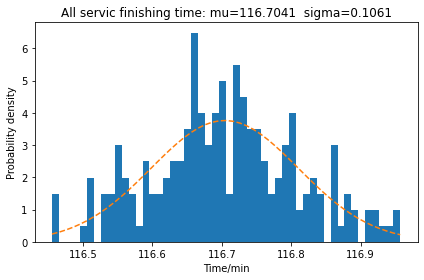

In [258]:
x0 = []
for i in range(200):
    print(i)
    x1 = []
    for j in range(20000):
        if j % 2000 == 0 :
            print("iteration", round(i/2, 2), "%: ", j//200, "%")
        x1.append(simulation_1.run(n_customers=20))
    x0.append(np.mean(x1))
x_warm_200_20000_1_1 = np.array(x0)
print(conf_int_95(x_warm_200_20000_1_1))

num_bins = 50
mu, sigma = np.mean(x_warm_200_20000_1_1), np.std(x_warm_200_20000_1_1)
fig, ax = plt.subplots()
ax.set_title('All servic finishing time: mu='+str(round(mu, 4))+'  sigma='+str(round(sigma, 4)))
ax.set_xlabel('Time/min')
ax.set_ylabel('Probability density')

n, bins, patches = ax.hist(x_warm_200_20000_1_1, num_bins, density=True)

y = ((1 / (np.sqrt(2 * np.pi) * sigma)) *
     np.exp(-0.5 * (1 / sigma * (bins - mu))**2))
ax.plot(bins, y, '--')

fig.tight_layout()
plt.show()

In [256]:
class simulation1_1:
    def run(n_customers):
        timer = []
        t = np.random.poisson(2.1, n_customers+10)
        for i in range(n_customers+10):
            timer.append((t[i], 'beta', 0))
        timer.sort(key= lambda k:k[0])
            
        stations = []
        stations.append(Station(stationid=0, overall_timer=timer, process_param=2.9, n_server=1, n_buffer=5))
        stations.append(Station(stationid=1, overall_timer=timer, process_param=2.2, n_server=2, n_buffer=6))
        stations.append(Station(stationid=2, overall_timer=timer, process_param=2.2, n_server=3, n_buffer=6))
        stations.append(Station(stationid=3, overall_timer=timer, process_param=2.8, n_server=1, n_buffer=3))
        stations[2].setnext(stations[3])
        stations[1].setnext(stations[2])
        stations[0].setnext(stations[1])
        
        st = 0
        tt = 0
        counter = 0
        while len(timer)>0:
            # print(timer)
            if counter >= 10:
                st = timer[0][0]
            tt = timer[0][0]
            succeed = stations[timer[0][2]].update(timer[0])
            if st == 0 and succeed:
                if timer[0][1]=='beta':
                    counter += 1
        return tt-st
            

In [259]:
x0 = []
for i in range(200):
    print(i)
    x1 = []
    for j in range(20000):
        if j % 2000 == 0 :
            print("iteration", round(i/2, 2), "%: ", j//200, "%")
        x1.append(simulation1_1.run(n_customers=20))
    x0.append(np.mean(x1))
x_warm_200_20000_2_3 = np.array(x0)
print(conf_int_95(x_warm_200_20000_2_3))

num_bins = 50
mu, sigma = np.mean(x_warm_200_20000_2_3), np.std(x_warm_200_20000_2_3)
fig, ax = plt.subplots()
ax.set_title('All servic finishing time: mu='+str(round(mu, 4))+'  sigma='+str(round(sigma, 4)))
ax.set_xlabel('Time/min')
ax.set_ylabel('Probability density')

n, bins, patches = ax.hist(x_warm_200_20000_2_3, num_bins, density=True)

y = ((1 / (np.sqrt(2 * np.pi) * sigma)) *
     np.exp(-0.5 * (1 / sigma * (bins - mu))**2))
ax.plot(bins, y, '--')

fig.tight_layout()
plt.show()

0
iteration 0.0 %:  0 %
iteration 0.0 %:  10 %
iteration 0.0 %:  20 %
iteration 0.0 %:  30 %
iteration 0.0 %:  40 %
iteration 0.0 %:  50 %
iteration 0.0 %:  60 %
iteration 0.0 %:  70 %
iteration 0.0 %:  80 %
iteration 0.0 %:  90 %
1
iteration 0.5 %:  0 %
iteration 0.5 %:  10 %
iteration 0.5 %:  20 %
iteration 0.5 %:  30 %
iteration 0.5 %:  40 %
iteration 0.5 %:  50 %
iteration 0.5 %:  60 %
iteration 0.5 %:  70 %
iteration 0.5 %:  80 %
iteration 0.5 %:  90 %
2
iteration 1.0 %:  0 %
iteration 1.0 %:  10 %
iteration 1.0 %:  20 %
iteration 1.0 %:  30 %
iteration 1.0 %:  40 %
iteration 1.0 %:  50 %
iteration 1.0 %:  60 %
iteration 1.0 %:  70 %
iteration 1.0 %:  80 %
iteration 1.0 %:  90 %
3
iteration 1.5 %:  0 %
iteration 1.5 %:  10 %
iteration 1.5 %:  20 %
iteration 1.5 %:  30 %
iteration 1.5 %:  40 %
iteration 1.5 %:  50 %
iteration 1.5 %:  60 %
iteration 1.5 %:  70 %
iteration 1.5 %:  80 %
iteration 1.5 %:  90 %
4
iteration 2.0 %:  0 %
iteration 2.0 %:  10 %
iteration 2.0 %:  20 %
iterat

iteration 17.0 %:  80 %
iteration 17.0 %:  90 %
35
iteration 17.5 %:  0 %
iteration 17.5 %:  10 %
iteration 17.5 %:  20 %
iteration 17.5 %:  30 %
iteration 17.5 %:  40 %
iteration 17.5 %:  50 %
iteration 17.5 %:  60 %
iteration 17.5 %:  70 %
iteration 17.5 %:  80 %
iteration 17.5 %:  90 %
36
iteration 18.0 %:  0 %
iteration 18.0 %:  10 %
iteration 18.0 %:  20 %
iteration 18.0 %:  30 %
iteration 18.0 %:  40 %
iteration 18.0 %:  50 %
iteration 18.0 %:  60 %
iteration 18.0 %:  70 %
iteration 18.0 %:  80 %
iteration 18.0 %:  90 %
37
iteration 18.5 %:  0 %
iteration 18.5 %:  10 %
iteration 18.5 %:  20 %
iteration 18.5 %:  30 %
iteration 18.5 %:  40 %
iteration 18.5 %:  50 %
iteration 18.5 %:  60 %
iteration 18.5 %:  70 %
iteration 18.5 %:  80 %
iteration 18.5 %:  90 %
38
iteration 19.0 %:  0 %
iteration 19.0 %:  10 %
iteration 19.0 %:  20 %
iteration 19.0 %:  30 %
iteration 19.0 %:  40 %
iteration 19.0 %:  50 %
iteration 19.0 %:  60 %
iteration 19.0 %:  70 %
iteration 19.0 %:  80 %
iteratio

iteration 34.0 %:  70 %
iteration 34.0 %:  80 %
iteration 34.0 %:  90 %
69
iteration 34.5 %:  0 %
iteration 34.5 %:  10 %
iteration 34.5 %:  20 %
iteration 34.5 %:  30 %
iteration 34.5 %:  40 %
iteration 34.5 %:  50 %
iteration 34.5 %:  60 %
iteration 34.5 %:  70 %
iteration 34.5 %:  80 %
iteration 34.5 %:  90 %
70
iteration 35.0 %:  0 %
iteration 35.0 %:  10 %
iteration 35.0 %:  20 %
iteration 35.0 %:  30 %
iteration 35.0 %:  40 %
iteration 35.0 %:  50 %
iteration 35.0 %:  60 %
iteration 35.0 %:  70 %
iteration 35.0 %:  80 %
iteration 35.0 %:  90 %
71
iteration 35.5 %:  0 %
iteration 35.5 %:  10 %
iteration 35.5 %:  20 %
iteration 35.5 %:  30 %
iteration 35.5 %:  40 %
iteration 35.5 %:  50 %
iteration 35.5 %:  60 %
iteration 35.5 %:  70 %
iteration 35.5 %:  80 %
iteration 35.5 %:  90 %
72
iteration 36.0 %:  0 %
iteration 36.0 %:  10 %
iteration 36.0 %:  20 %
iteration 36.0 %:  30 %
iteration 36.0 %:  40 %
iteration 36.0 %:  50 %
iteration 36.0 %:  60 %
iteration 36.0 %:  70 %
iteratio

KeyboardInterrupt: 